# Support Vector Machines 
**Author: Maximilian Forstenhäusler** <br><br><br>
As part of the Seminar: Advanced Topics in Quantum Computing at [TUM](https://www.tum.de/), this notebook experiments with the implementation of Quantum Support Vector Machines. The project entails two notebooks.
- In this notebook I benchmark my custom implementation of the classical Support Vector Machine Algorithm against [`scikit-learn`](https://scikit-learn.org/stable/) implementation before exploring and additionally benchmarking my custom implementation of  Qunatum Support Vector Machines with the implementatino by [`qiskit`](https://www.qiskit.org/).
- For more inside on the Quantum SVM implementation, see the other notebook -> [Quantum Support Vector Machines](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/Quantum%20Support%20Vector%20Machines.ipynb) 

The source code:
- [linear classifier](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/svm/linear_classifier.py)
- [nonlinear classifier](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/svm/linear_classifier.py)
- [quantum feature map](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/quantum/feature_maps.py)
- [quantum kernel estimate](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/quantum_svm/quantum/kernels.py)

For the full code --> [github/mforstenhaeusler/QSVM](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines)

## Content
To make it easier to navigate through the notebook, you can click on the links to navigate directly to the section of interest.

1. [Hard Margin SVM](#Hard-Margin-SVM)
2. [Soft Margin SVM](#Soft-Margin-SVM)
3. [Kernel Methods](#Kernel-Methods) \
    3.1 [Not linearly seperable Data](#Let's-look-at-not-linearly-seperable-data)\
    3.2 [Polynominal Kernel](#Polynominal-Kernel)\
    3.2 [Radial Basis Function](#Radial-Basis-Function-(rbf)) \
    3.3 [Quantum Kernel](#Quantum-Kernel) \
    3.4 [Benchmark custom QSVC](#Compare-custom-QSVC-with-scikit-learn-SVC-with-qiskit-kernel) 
4. [Adhoc Data](#Adhoc-Data) 
5. [Kernel Comparison](#Kernel-Comparison)
6. [References](#References)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.svm import SVC

from quantum_svm.utils.utils import compare_models, compare_model_performance
from quantum_svm.data.data_generators import create_bipolar_data, create_XOR_data, create_moons_data, create_circles_data, adhoc_dataset
from quantum_svm.svm.linear_classifier import linearSVC
from quantum_svm.svm.nonlinear_classifier import kernelSVC
from quantum_svm.utils.plot import (
    plot_data, 
    plot_confusion_matrix, 
    plot_SVM, 
    plot_datasets, 
    plot_adhoc, 
    plot_kernel_SVC
)
from quantum_svm.utils.utils import accuracy
%load_ext autoreload

%autoreload 2

#### Global Params

In [2]:

alpha_tol = 1e-04
colors = ['red', 'blue']
cmap_custom = pltcolors.ListedColormap(colors)
cmap = plt.cm.RdBu_r

seed = 12

#### Datasets

In [3]:
# dataset params
params_bipolar_hard = {
    'N': 200, # number of samples
    'D': 2, # number of dimensions
    'C': 2, # number of classes 
    'sigma': 0.5, # std
    'seed': seed,
}

params_bipolar_soft = {
    'N': 200, # number of samples
    'D': 2, # number of dimensions
    'C': 2, # number of classes 
    'sigma': 1.2, # std
    'seed': seed,
}

center = 1
params_xor = {
    'N': 100, # number of samples
    'D': 2, # number of dimensions
    'sigma': 0.4, # std
    'centers': [[center,center], [-center,center], [center,-center], [-center,-center]], 
    'seed': seed,
}


params_circles = {
    'N': 200, # number of samples
    'factor': 0.4, 
    'noise': 0.1,
    'seed': seed,
}

params_moons = {
    'N': 200, # number of samples
    'noise': 0.15,
    'seed': seed,
}

params_adhoc = {
    'train_size': 40,
    'test_size': 10,
    'adhoc_dimension': 2,
    'gap': 0.3,
}

In [4]:
# initialize list of datasets
datasets = [
    create_bipolar_data(
        params_bipolar_hard['N'], 
        params_bipolar_hard['D'], 
        params_bipolar_hard['C'], 
        params_bipolar_hard['sigma'], 
        params_bipolar_hard['seed']
    ),
    create_bipolar_data(
        params_bipolar_soft['N'], 
        params_bipolar_soft['D'], 
        params_bipolar_soft['C'], 
        params_bipolar_soft['sigma'], 
        params_bipolar_soft['seed']
    ),
    create_XOR_data(
        params_xor['N'], 
        params_xor['D'], 
        params_xor['centers'], 
        params_xor['sigma'], 
        params_xor['seed']
    ),
    create_circles_data(
        params_circles['N'], 
        params_circles['factor'], 
        params_circles['noise'], 
        params_circles['seed']
    ),
    create_moons_data(
        params_moons['N'], 
        params_moons['noise'], 
        params_moons['seed']
    ),
    adhoc_dataset(
        params_adhoc['train_size'], 
        params_adhoc['test_size'], 
        params_adhoc['adhoc_dimension'],
        params_adhoc['gap']
    ),
]

plot_titles = [
    'Linearaly Seperable Data - large margin',
    'Linearaly Seperable Data - no margin',
    'XOR Data',
    'Circles Data',
    'Moons Data', 
    'Adhoc Data'
]


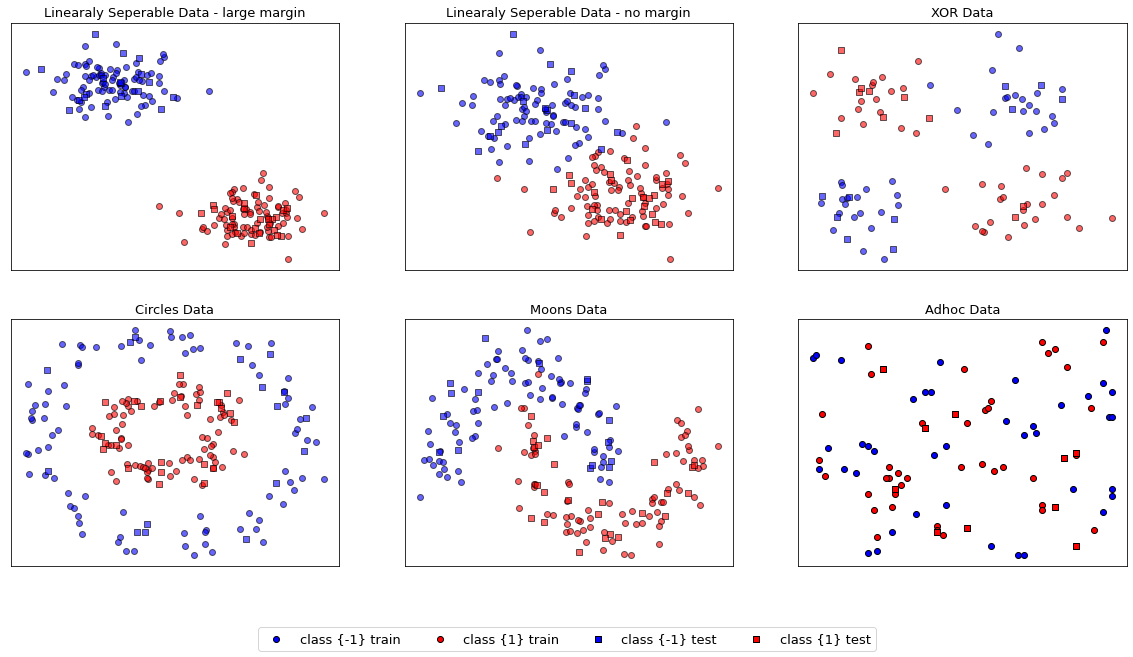

In [5]:
# plots datasets
plot_datasets(datasets, plot_titles)

In [6]:
#### Base-Line Models 

In [7]:
#baseline_hard_margin_SVC = SVC(kernel='linear', C=10000)
#baseline_soft_margin_SVC = SVC(kernel='linear', C=10)
#baseline_linear_kernel_SVC = SVC(kernel='linear', C=10)
#baseline_poly_kernel_SVC = SVC(kernel='poly', C=10, degree=3)
#baseline_rbf_kernel_SVC = SVC(kernel='rbf', C=10, gamma=0.5)

[Return to Content](#Content)

## Hard Margin SVM

Solves the follwing constrained optimaztion problem.
\begin{align}
    &\min \frac{1}{2} \lvert\lvert \textbf{w}\rvert\rvert^2 \\
    &\textit{s.t. } y_I(w^Tx_i + b -1) \geq 0 \text{ for i = 1, ..., N}
\end{align}

**Primal:**
\begin{align} 
             \mathcal{L}(w,b,\alpha) &= \frac{1}{2}w^Tw - \sum_{i=1}^N \alpha_i(y_i(w^Tx_i + b) -1)\\
            g(\alpha) &= \min_{w,b} \mathcal{L}(w,b,\alpha)\\
            \nabla_w \mathcal{L}(w,b,\alpha) &= w - \sum_{i=1}^N \alpha_i y_i x_i \overset{!}{=} 0 \\
            \nabla_b \mathcal{L}(w,b,\alpha) &= - \sum_{i=1}^N \alpha_i y_i \overset{!}{=} 0 
\end{align}
**Dual:**
\begin{equation}
        \begin{split} 
            &\max_{\alpha}\hspace{0.15cm} g(\alpha) = \mathcal{L}(w^*,b^*,\alpha) = \sum_{i=1}^N \alpha_i -\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^Tx_j \\
            &\textit{s.t.}  \hspace{0.15cm} \sum_{i=1}^N \alpha_i y_i = 0, \hspace{0.15cm} \alpha_i \geq 0 \hspace{0.15cm} \text{for } i = 1, ..., N
    \end{split}
\end{equation}

$\rightarrow$ Quadratic Programming Problem which can be implemented by the [`cvxopt`](https://www.cvxopt.org/) library.

rearange dual to following form:
\begin{equation}
    \begin{split}
        \min_{\alpha}\hspace{0.15cm} &\frac{1}{2} \mathbf{\alpha}^T \mathbf{P}\mathbf{\alpha} - \mathbf{1}_N^T\boldsymbol{\alpha} \\
        \textit{s.t.}  \hspace{0.15cm} y^T \alpha &= 0, \hspace{0.15cm} -\alpha_i \leq 0 \hspace{0.15cm} \text{for } i = 1, ..., N
    \end{split}
\end{equation}

where,
\begin{align*}
    \mathbf{q} &:= -\mathbf{1_N} \in \mathbb{R}^{Nx1}\\
    \mathbf{P} &:=  yy^T \circ x^Tx \in\mathbb{R}^{NxN}\\
    \mathbf{G} &:= -\mathbf{diag(1_N)} \in \mathbb{R}^{NxN}\\
    \mathbf{h} &:= \mathbf{0_N} \in \mathbb{R}^{Nx1}\\
    \mathbf{A} &:= \mathbf{y} \in \mathbb{R}^{Nx1}\\
    \mathbf{b} &:= 0 \in \mathbb{R}
\end{align*}

In [8]:
# Load data
X_bi_train, X_bi_test, y_bi_train, y_bi_test = datasets[0]

# Initialize Model 
hard_margin_SVC = linearSVC()

In [9]:
# Fit Model
hard_margin_SVC.fit(X_bi_train, y_bi_train)
params = hard_margin_SVC.compute_params()

Found 3 Support Vectors out of 160 data points


Weights: [ 2.03731128 -4.75300436]
Bias: 1.1954408506619825
Decision Hyperplane: 0.4286365255878248 * x + 0.25151267684329354 


Accuracy on train set: 100.0 %


In [10]:
# Precict
y_pred_hard_margin = hard_margin_SVC.predict(X_bi_test)

In [11]:
# Baseline
baseline_hard_margin_SVC = SVC(kernel='linear', C=10000)

# Fit
baseline_hard_margin_SVC.fit(X_bi_train, y_bi_train)

SVC(C=10000, kernel='linear')

In [12]:
# Predict
y_pred_baseline_hard_margin = baseline_hard_margin_SVC.predict(X_bi_test)

#Accuracy
baseline_acc_hard_margin= baseline_hard_margin_SVC.score(X_bi_test, y_bi_test)

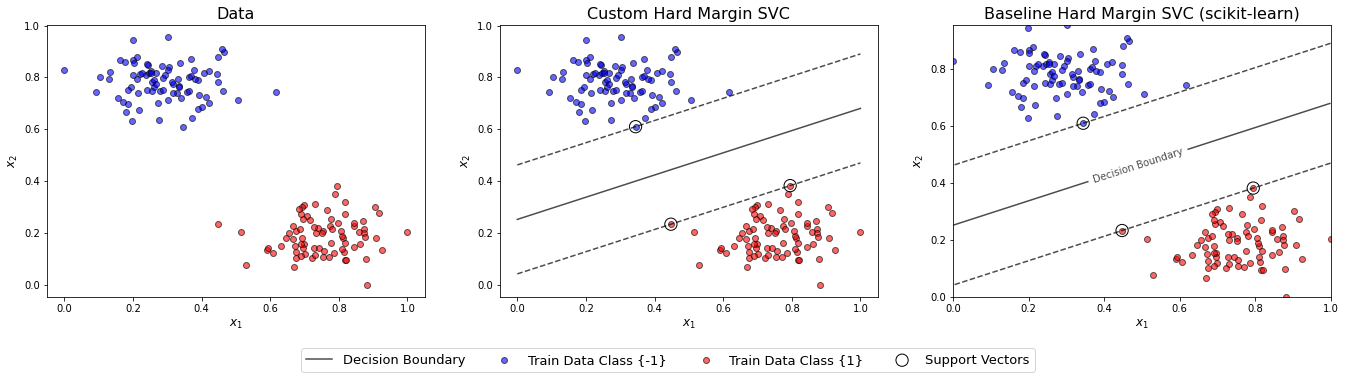

In [13]:
plot_SVM(
    X_bi_train, 
    y_bi_train, 
    params, 
    baseline_hard_margin_SVC, 
    titles = ["Data", "Custom Hard Margin SVC", "Baseline Hard Margin SVC (scikit-learn)"],
    sv=True, 
    hyperplane=True)


In [14]:
# accuracy
accuracy(y_bi_test, y_pred_hard_margin, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_hard_margin*100} %')

Accuracy on test set: 100.0 %
Baseline Accuracy: 100.0 %


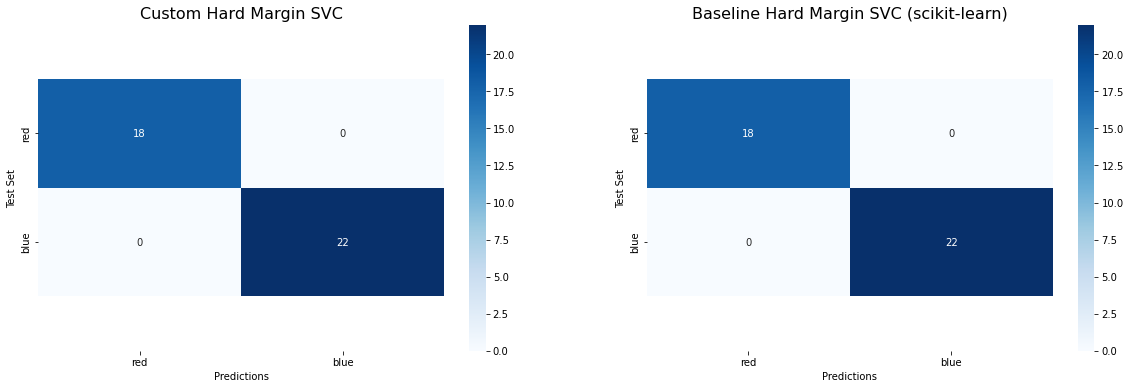

In [15]:
# confusion Matrix plot
plot_confusion_matrix(
    y_bi_test, 
    y_pred_hard_margin,
    y_pred_baseline_hard_margin,
    colors, 
    titles=["Custom Hard Margin SVC", "Baseline Hard Margin SVC (scikit-learn)"]
)

[Return to Content](#Content)

## Soft Margin SVM

Introduce Slack varibles $\xi$ that measure the voilation of the margin.
\begin{equation}
    \begin{split}
        &\min \hspace{0.15cm} \frac{1}{2}||w||^2_2 + C \sum_{i=1}^N \xi_i\\
        &\textit{s.t.} \hspace{0.15cm} y_i(w^Tx_i + b -1) \geq 1 - \xi_i \hspace{0.15cm}\forall_i 
    \end{split}
\end{equation} where C is the punishment for voilating the margin.

$\rightarrow$ The _Quadratic Programming Problem_ is 
\begin{align}
    \min_{\alpha}\hspace{0.15cm} &\frac{1}{2} \mathbf{\alpha}^T \mathbf{P}\mathbf{\alpha} - \mathbf{1}_N^T\boldsymbol{\alpha} \\
    \textit{s.t.}  \hspace{0.15cm} &y^T \alpha = 0 \\ 
    & -\alpha_i \leq 0 \hspace{0.15cm} \text{for } i = 1, ..., N\\
    & \alpha_i \leq C \hspace{0.15cm} \text{for } i = 1, ..., N
\end{align}


\begin{align*}
    &&\mathbf{q} &:= -\mathbf{1_N} \in \mathbb{R}^{Nx1}\\
    &&\mathbf{P} &:=  \mathbf{Q}  \in\mathbb{R}^{NxN}\\
    &&\mathbf{G} &:= - \begin{pmatrix} -\mathbf{diag(1_N)} \\ \mathbf{diag(1_N)}\end{pmatrix}\in              \mathbb{R}^{2NxN}\\ 
    &&\mathbf{h} &:= \begin{pmatrix} \mathbf{0_N} && C\cdot \mathbf{1_N} \end{pmatrix} \in \mathbb{R}^{2N \times 1}\\
    &&\mathbf{A} &:= \mathbf{y} \in \mathbb{R}^{Nx1}\\
    &&\mathbf{b} &:= 0 \in \mathbb{R}
\end{align*}

In [16]:
# Load Data
X_bi_soft_train, X_bi_soft_test, y_bi_soft_train, y_bi_soft_test = datasets[1]

# Initialize Model
soft_margin_SVC = linearSVC(C=10)

In [17]:
# Fit Model
soft_margin_SVC.fit(X_bi_soft_train, y_bi_soft_train)
params = soft_margin_SVC.compute_params()

Found 24 Support Vectors out of 160 data points


Weights: [ 5.14872057 -8.55166523]
Bias: 1.249749573971498
Decision Hyperplane: 0.6020722791139658 * x + 0.14614107791459807 


Accuracy on train set: 97.5 %


In [18]:
# Predict
y_pred_soft_margin = soft_margin_SVC.predict(X_bi_soft_test)

In [19]:
# Baseline 
baseline_soft_margin_SVC = SVC(kernel='linear', C=10)

# Fit
baseline_soft_margin_SVC.fit(X_bi_soft_train, y_bi_soft_train)

SVC(C=10, kernel='linear')

In [20]:
# Predict
y_pred_baseline_soft_margin = baseline_soft_margin_SVC.predict(X_bi_soft_test)

#Accuracy
baseline_acc_soft_margin = baseline_soft_margin_SVC.score(X_bi_soft_test, y_bi_soft_test)

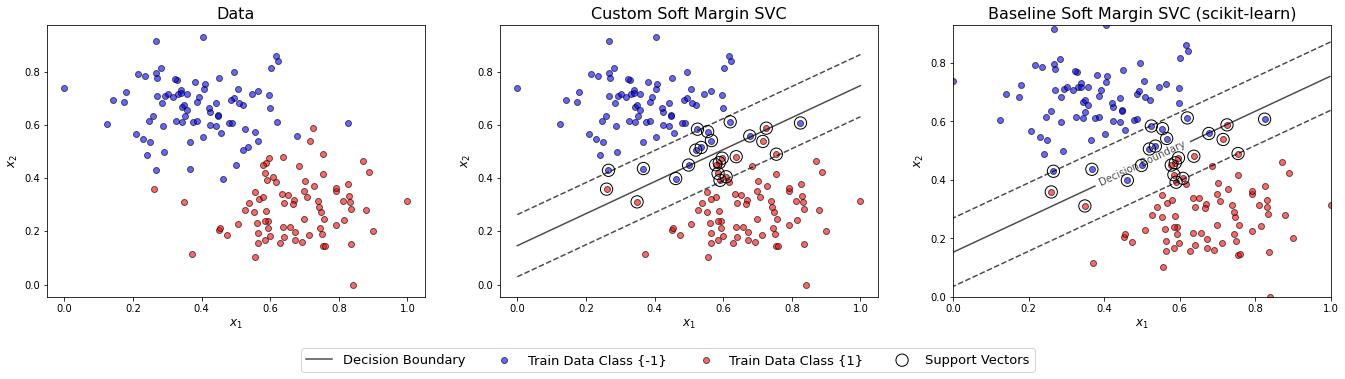

In [21]:
plot_SVM(
    X_bi_soft_train, 
    y_bi_soft_train,  
    params, 
    baseline_soft_margin_SVC, 
    titles = ["Data", "Custom Soft Margin SVC", "Baseline Soft Margin SVC (scikit-learn)"],
    sv=True, 
    hyperplane=True)

In [22]:
# accuracy

accuracy(y_bi_soft_test, y_pred_baseline_soft_margin, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_soft_margin*100} %')

Accuracy on test set: 97.5 %
Baseline Accuracy: 97.5 %


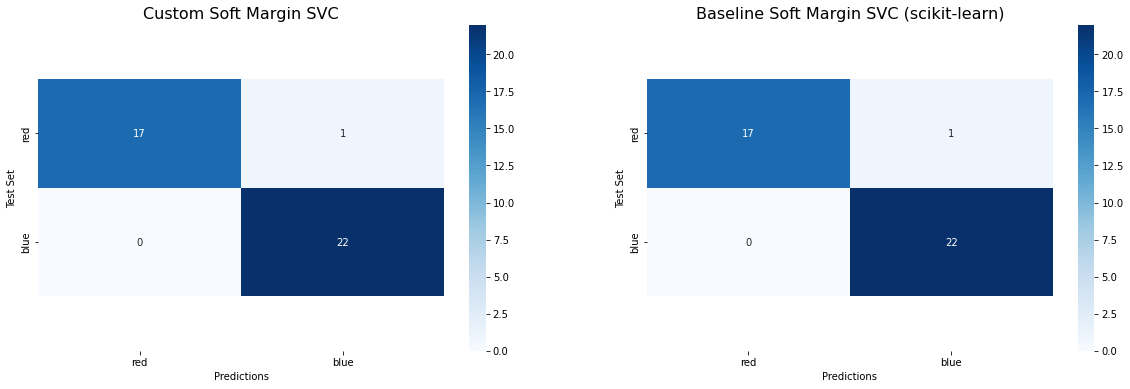

In [23]:
# confusion Matrix plot
plot_confusion_matrix(
    y_bi_soft_test, 
    y_pred_soft_margin,
    y_pred_baseline_soft_margin,
    colors, 
    titles=["Custom Soft Margin SVC", "Baseline Soft Margin SVC (scikit-learn)"]
)

[Return to Content](#Content)

## Kernel Methods

The **Kernel Trick** in combination with the introduction of a basis functions, $\phi(\cdot): \mathbb{R}^N \rightarrow \mathbb{R}^M $, that allows the data to be map to a higher dimensinal freature space, **Hilbert Space**, enables an increased classification performance.

#### Let's look at not linearly seperable data

In [24]:
# Load Data
X_xor_train, X_xor_test, y_xor_train, y_xor_test = datasets[2]

# Initialize Model
linear_SVC = kernelSVC(kernel='linear', C=10)

SVC(kernel='linear', C=10.0)


In [25]:
# Fit Model
linear_SVC.fit(X_xor_train, y_xor_train)

Found 74 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 3228.16batch/s]


Accuracy on training set: 53.75 %


In [26]:
# Predict
y_pred_linear_SVC = linear_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 1976.44batch/s]


In [27]:
# Baseline 
baseline_linear_kernel_SVC = SVC(kernel='linear', C=10)

# Fit
baseline_linear_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, kernel='linear')

In [28]:
# predict
y_pred_baseline_soft_margin_xor = baseline_linear_kernel_SVC.predict(X_xor_test)
baseline_acc_soft_margin_xor = baseline_linear_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3795.90batch/s]


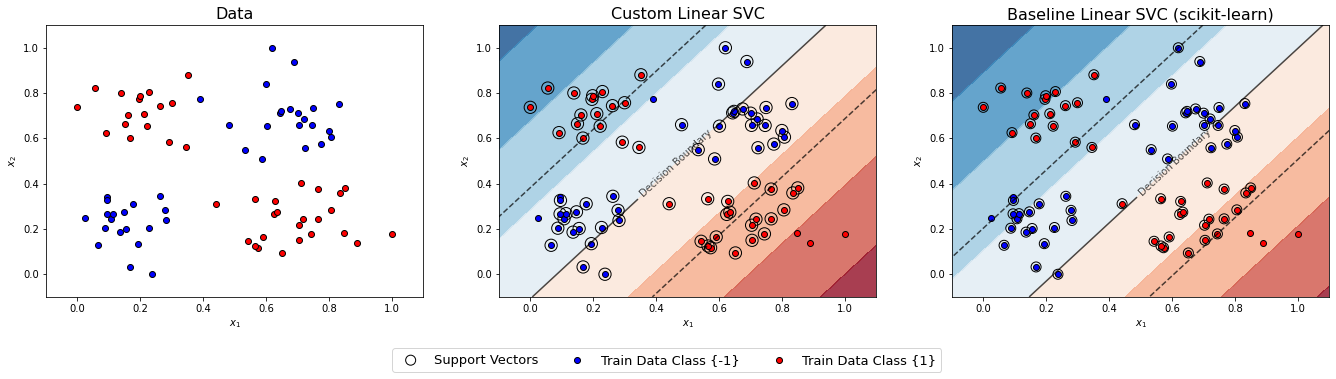

In [29]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [linear_SVC, baseline_linear_kernel_SVC],
    cmap, 
    titles=["Data", "Custom Linear SVC", "Baseline Linear SVC (scikit-learn)"], 
    kernel='polynominal',
)

In [30]:
# accuracy
accuracy(y_xor_test, y_pred_linear_SVC, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_soft_margin_xor*100} %')

Accuracy on test set: 35.0 %
Baseline Accuracy: 50.0 %


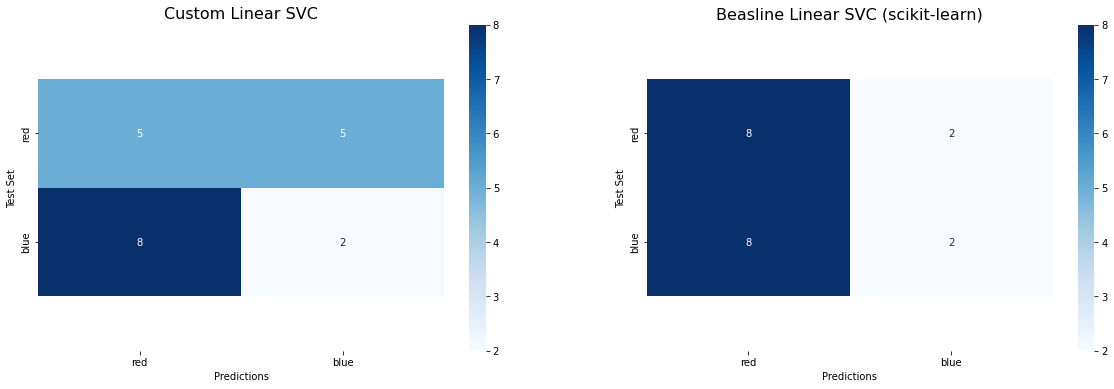

In [31]:
# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_pred_linear_SVC,
    y_pred_baseline_soft_margin_xor,
    colors, 
    titles=["Custom Linear SVC", "Beasline Linear SVC (scikit-learn)"]
)

[Return to Content](#Content)

### Polynominal Kernel

In [32]:
# Initialize Polynominal SVC
polynominal_SVC = kernelSVC(kernel='polynominal', C=10, degree=3)

SVC(kernel='polynominal', C=10.0, degree=3)


In [33]:
# Fit Model
polynominal_SVC.fit(X_xor_train, y_xor_train)

Found 22 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 5760.32batch/s]


Accuracy on training set: 96.25 %


In [34]:
# Predict
y_xor_pred_poly = polynominal_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 4905.33batch/s]


In [35]:
# Baseline 
baseline_poly_kernel_SVC = SVC(kernel='poly', C=10, degree=3)

# Fit
baseline_poly_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, kernel='poly')

In [36]:
# Predict
y_xor_pred_baseline_poly = baseline_poly_kernel_SVC.predict(X_xor_test)

# Accuracy
baseline_acc_poly = baseline_poly_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 8146.70batch/s]


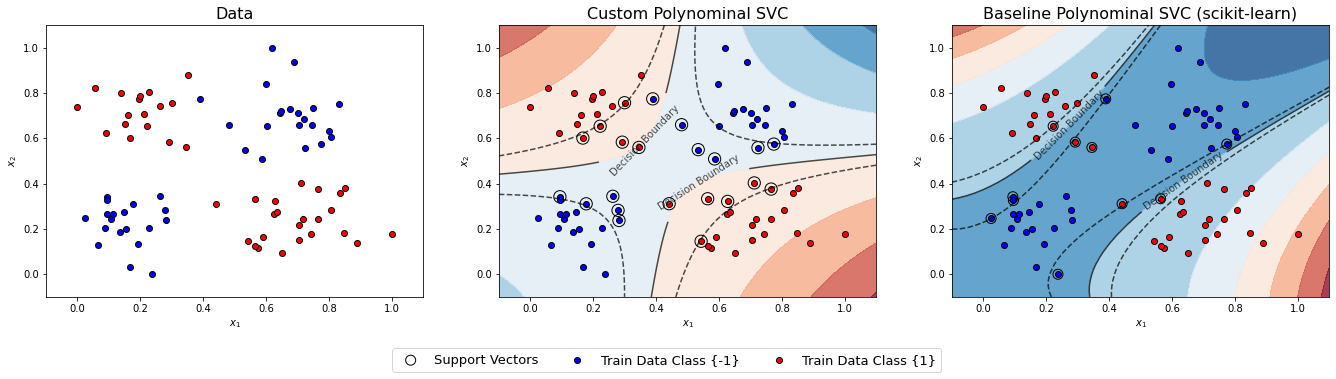

In [37]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [polynominal_SVC, baseline_poly_kernel_SVC],
    cmap, 
    titles=["Data", "Custom Polynominal SVC", "Baseline Polynominal SVC (scikit-learn)"], 
    kernel='polynominal'
)

In [38]:
# accuracy
accuracy(y_xor_test, y_xor_pred_poly, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_poly*100} %')

Accuracy on test set: 95.0 %
Baseline Accuracy: 95.0 %


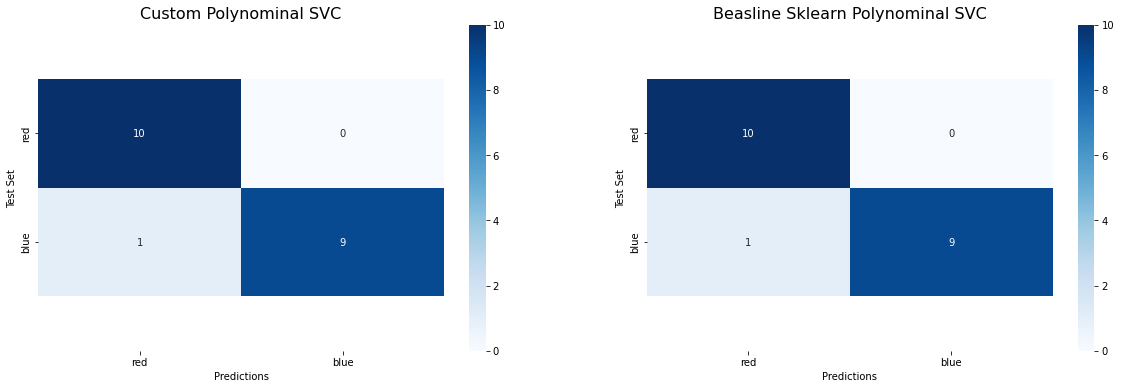

In [39]:
# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_poly,
    y_xor_pred_baseline_poly,
    colors, 
    titles=["Custom Polynominal SVC", "Beasline Sklearn Polynominal SVC"]
)

[Return to Content](#Content)

### Radial Basis Function (rbf)

In [40]:
# Initialize Model
rbf_SVC = kernelSVC(kernel='rbf', C=10)

# Fit Model
rbf_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel='rbf', C=10.0, gamma=0.5)
Found 49 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 1478.29batch/s]


Accuracy on training set: 98.75 %


In [41]:
# Predict
y_xor_pred_rbf = rbf_SVC.predict(X_xor_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 2315.63batch/s]


In [42]:
# Baseline 
baseline_rbf_kernel_SVC = SVC(kernel='rbf', C=10, gamma=0.5)

# Fit
baseline_rbf_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(C=10, gamma=0.5)

In [43]:
# Predict
y_xor_pred_baseline_rbf = baseline_rbf_kernel_SVC.predict(X_xor_test)

# Accuracy
baseline_acc_rbf = baseline_rbf_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████| 2500/2500 [00:01<00:00, 2396.25batch/s]


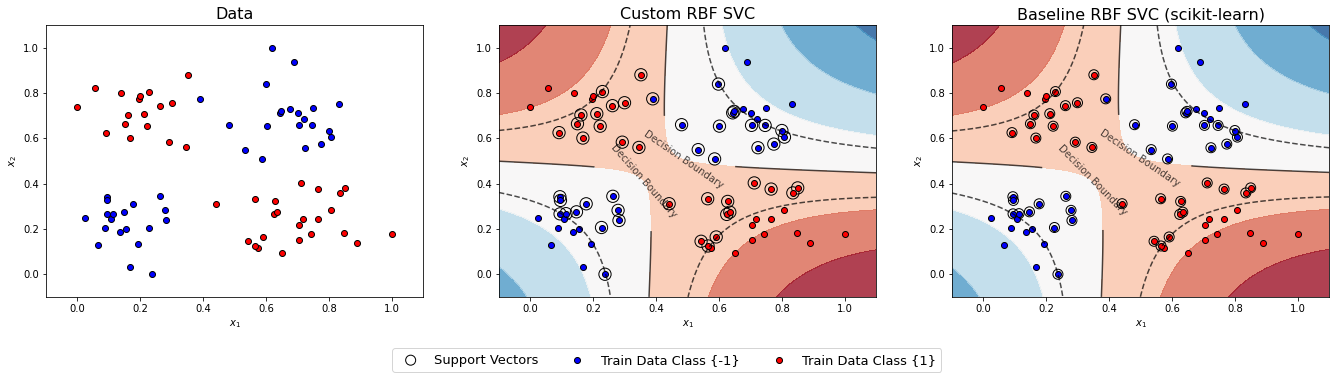

In [44]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [rbf_SVC, baseline_rbf_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf'
)

In [45]:
# accuracy
accuracy(y_xor_test, y_xor_pred_rbf, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_rbf*100} %')

Accuracy on test set: 100.0 %
Baseline Accuracy: 100.0 %


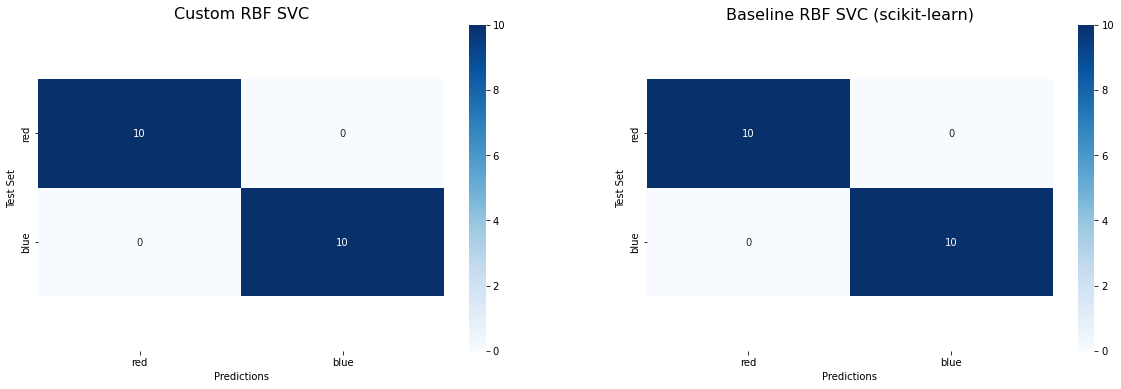

In [46]:
# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_rbf,
    y_xor_pred_baseline_rbf,
    colors, 
    titles=["Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"]
)

### Display Kernels

In [47]:
## get kernel functions
K_linear = linear_SVC.get_kernel_matrix()
K_poly = polynominal_SVC.get_kernel_matrix()
K_rbf = rbf_SVC.get_kernel_matrix()

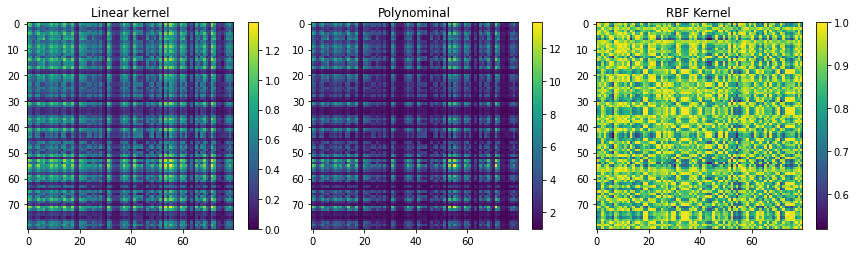

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(K_linear),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[0].set_title("Linear kernel")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[1].imshow(np.asmatrix(K_poly),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Polynominal")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(np.asmatrix(K_rbf),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("RBF Kernel")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()

[Return to Content](#Content)

### Quantum Kernel

#### Theory
In order to use a quantum kernel, one needs to transform the classical data to a quantum state.
#### Quantum Feature Maps 
- maps a classical state vector x to a quantum state vector (Hilbert Space)
- this is done by $$ \mathbf{U}_{\Phi}(x) = \prod_d U_{\Phi}(x)\mathcal{H}^{\otimes n}$$
**ZZ Feature Map**
$$ \mathbf{U}_{\Phi}(x) = ( \exp(i \sum_{jk} \phi_{j,k}(x) Z_j \otimes Z_k) \exp(i \sum_{j} \phi_{j}(x) Z_j)  \mathcal{H}^{\otimes n})^d$$
The feature map is realized by a quantum circuit.  
#### Quantum Kernel

$$ k(x_i, x_j) = \Phi^{\dagger}(x_i) \Phi(x_j)$$ 
for finite data:
$$ K_{ij} = |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 $$

$$|\Phi(x_j)> = U_{\theta}(x_j)|0^{\otimes n}>$$

to calculate each element --> calc the transition amplitude 
$$ |<\Phi^{\dagger}(x_i)|\Phi(x_j)>|^2 = |<0^{\otimes n}|U_{\theta}^{\dagger}(x_i)|U_{\theta}(x_j)|0^{\otimes n}>|^2$$ <br>
** **For more information:** [Slides](https://github.com/mforstenhaeusler/Quantum-Support-Vector-Machines/blob/main/Slides/Quantum_Support_Vector_Machines_final.pdf)

In [49]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit import Aer

from quantum_svm.quantum.kernel_loader import quantum_kernel_loader
from quantum_svm.quantum.kernels import QuantumKernel 
from quantum_svm.quantum.feature_maps import ZZFeatureMap as ZZFeatureMap_custom 
from quantum_svm.quantum.data_maps import DataMap, DataMap_Exp, DataMap_Sin, DataMap_Cos

In [50]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 1,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

data_map = DataMap()

zz_feature_map_custom = ZZFeatureMap_custom(
    quantum_params['feature_dimension'], 
    quantum_params['reps'], 
    data_map, 
    insert_barriers=True
)

In [51]:
backend = Aer.get_backend('qasm_simulator')

zz_kernel = QuantumKernel(feature_map=zz_feature_map_custom, quantum_backend=backend, sim_params=quantum_params)

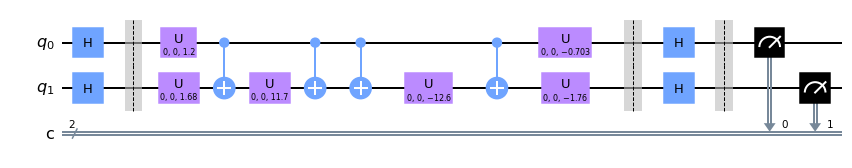

In [52]:
zz_circuit = zz_kernel.construct_circuit(X_xor_train[0], X_xor_train[1])
zz_circuit.decompose().draw(output='mpl')

### Compare custom QSVC with scikit-learn SVC with qiskit kernel

In [53]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

In [54]:
data_map = DataMap()

In [56]:
# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    data_map=data_map,
    qiskit=False
)

# train 
quantum_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel='quantum', feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0]) if S={i,j}')
Computing Quantum Kernel ...
Quantum Kernel computed!
Found 10 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:19<00:00,  1.00batch/s]


Accuracy on training set: 100.0 %


In [57]:
# Predict
y_xor_pred_quantum = quantum_SVC.predict(X_xor_test)

100%|████████████████████████████████████████| 20/20 [00:19<00:00,  1.02batch/s]


In [58]:
# baseline
QK = quantum_kernel_loader(quantum_params)
baseline_quantum_kernel_SVC = SVC(kernel=QK)
baseline_quantum_kernel_SVC.fit(X_xor_train, y_xor_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f876c41f910>>)

In [59]:
y_xor_pred_baseline_quantum = baseline_quantum_kernel_SVC.predict(X_xor_test)
baseline_acc_quantum = baseline_quantum_kernel_SVC.score(X_xor_test, y_xor_test)

100%|██████████████████████████████████████| 400/400 [07:40<00:00,  1.15s/batch]


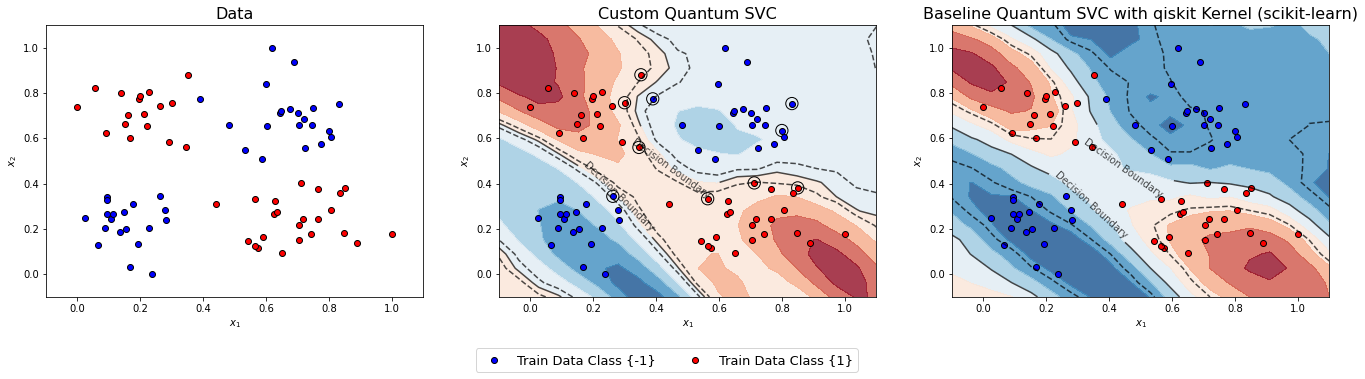

In [60]:
plot_kernel_SVC(
    X_xor_train, 
    y_xor_train, 
    [quantum_SVC, baseline_quantum_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Baseline Quantum SVC with qiskit Kernel (scikit-learn)"], 
    kernel='quantum')

Accuracy on test set: 95.0 %
Baseline Accuracy: 95.0 %


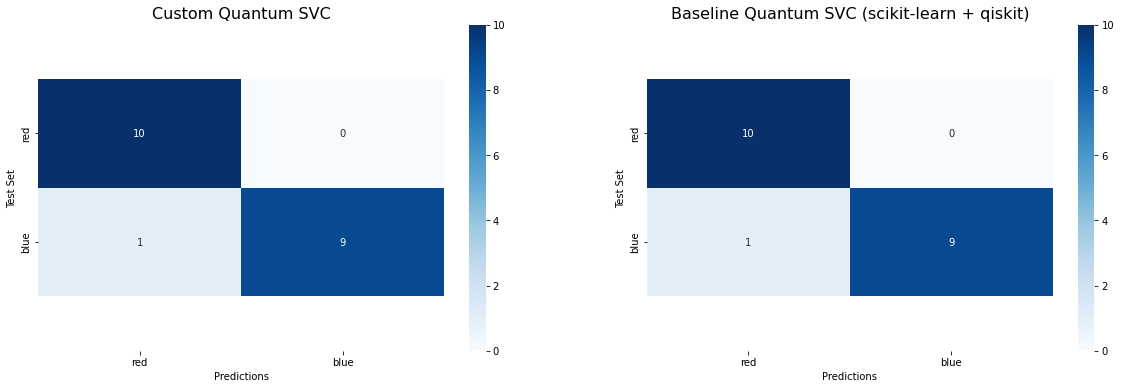

In [61]:
# accuracy
accuracy(y_xor_test, y_xor_pred_quantum, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_quantum*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_xor_test, 
    y_xor_pred_quantum,
    y_xor_pred_baseline_quantum,
    colors, 
    titles=["Custom Quantum SVC", "Baseline Quantum SVC (scikit-learn + qiskit)"]
)

In [62]:
K_quantum = quantum_SVC.get_kernel_matrix()

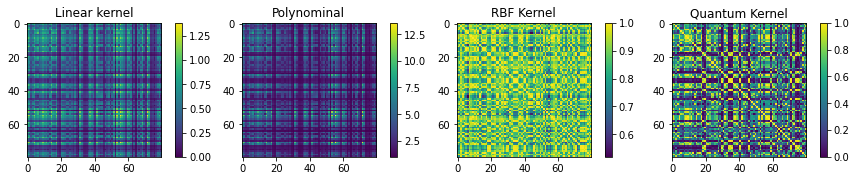

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(12, 12))
im = ax[0].imshow(np.asmatrix(K_linear),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[0].set_title("Linear kernel")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[1].imshow(np.asmatrix(K_poly),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[1].set_title("Polynominal")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[2].imshow(np.asmatrix(K_rbf),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[2].set_title("RBF Kernel")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

im = ax[3].imshow(np.asmatrix(K_quantum),
              interpolation='nearest', origin='upper', cmap=plt.cm.viridis)
ax[3].set_title("Quantum Kernel")
divider = make_axes_locatable(ax[3])
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

fig.tight_layout()
plt.show()

[Return to Content](#Content)

## Adhoc Dataset

https://arxiv.org/pdf/1804.11326.pdf

In [64]:
# Load Data
X_adhoc_train, y_adhoc_train, X_adhoc_test, y_adhoc_test, adhoc_total = datasets[-1]

### Radial Basis Function (rbf)

In [71]:
# Initialize Model
rbf_SVC_adhoc = kernelSVC(kernel='rbf', C=10)

# Fit Model
rbf_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(kernel='rbf', C=10.0, gamma=0.5)
Found 51 Support Vectors out of 80 data points




100%|██████████████████████████████████████| 80/80 [00:00<00:00, 2303.88batch/s]


Accuracy on training set: 87.5 %


In [72]:
# Predict
y_adhoc_pred_rbf = rbf_SVC_adhoc.predict(X_adhoc_test)

100%|██████████████████████████████████████| 20/20 [00:00<00:00, 2507.58batch/s]


In [73]:
# Baseline 
baseline_rbf_kernel_SVC_adhoc = SVC(kernel='rbf', C=10, gamma=0.5)

# Fit
baseline_rbf_kernel_SVC_adhoc.fit(X_adhoc_train, y_adhoc_train)

SVC(C=10, gamma=0.5)

In [74]:
# Predict
y_adhoc_pred_baseline_rbf = baseline_rbf_kernel_SVC_adhoc.predict(X_adhoc_test)

# Accuracy
baseline_acc_rbf_adhoc = baseline_rbf_kernel_SVC_adhoc.score(X_adhoc_test, y_adhoc_test)

100%|██████████████████████████████████| 2500/2500 [00:00<00:00, 3564.89batch/s]


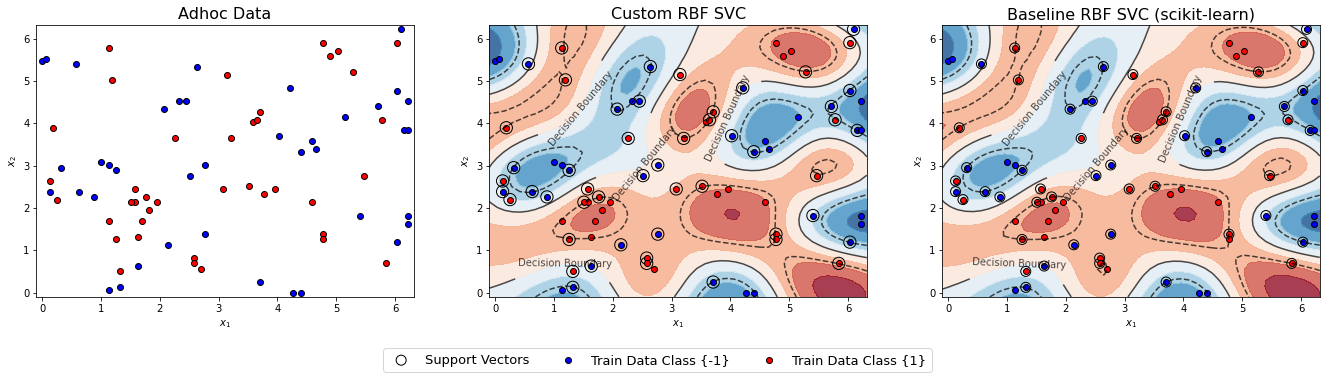

In [75]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [rbf_SVC_adhoc, baseline_rbf_kernel_SVC_adhoc], 
    cmap, 
    titles=["Adhoc Data", "Custom RBF SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='rbf'
)


Accuracy on test set: 70.0 %
Baseline Accuracy: 70.0 %


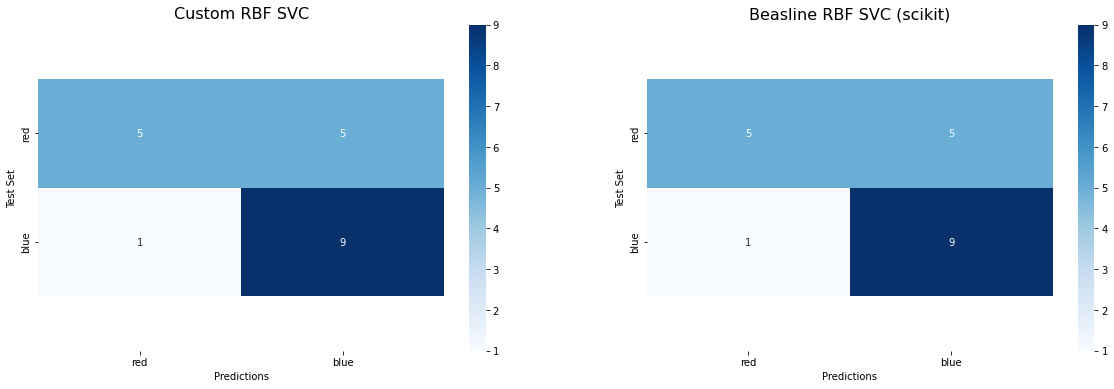

In [76]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_rbf_adhoc*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_rbf,
    y_adhoc_pred_baseline_rbf,
    colors, 
    titles=["Custom RBF SVC", "Beasline RBF SVC (scikit)"]
)

### Quantum Kernel

In [78]:
quantum_params = {
    'feature_dimension': 2,
    'reps': 2,
    'seed': 1024,
    'shots': 2**14,   
    'provider_backend': Aer.get_backend('qasm_simulator'),
}

#data_map = DataMap()

# set up quntum kernel 
quantum_SVC = kernelSVC(
    kernel='quantum', 
    quantum_params=quantum_params,
    #data_map=data_map,
    qiskit=False
)

SVC(kernel='quantum', feature_map='ZZFeatureMap', data_map='default DataMap')


In [79]:
# train 
quantum_SVC.fit(X_adhoc_train, y_adhoc_train)

Computing Quantum Kernel ...
Quantum Kernel computed!
Found 15 Support Vectors out of 80 data points




100%|████████████████████████████████████████| 80/80 [01:55<00:00,  1.44s/batch]


Accuracy on training set: 100.0 %


In [80]:
y_adhoc_pred_quantum = quantum_SVC.predict(X_adhoc_test)

100%|████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/batch]


In [81]:
# baseline
QK = quantum_kernel_loader(quantum_params)
baseline_quantum_kernel_SVC = SVC(kernel=QK)
baseline_quantum_kernel_SVC.fit(X_adhoc_train, y_adhoc_train)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f8721fa3590>>)

In [82]:
y_adhoc_pred_baseline_quantum = baseline_quantum_kernel_SVC.predict(X_adhoc_test)
baseline_acc_adhoc_quantum = baseline_quantum_kernel_SVC.score(X_adhoc_test, y_adhoc_test)

100%|██████████████████████████████████████| 400/400 [10:04<00:00,  1.51s/batch]


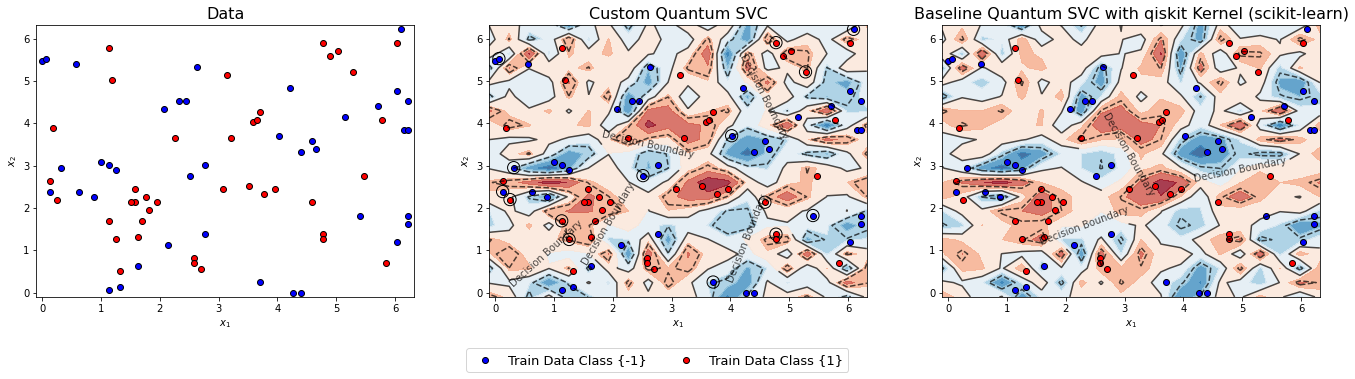

In [83]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC, baseline_quantum_kernel_SVC], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Baseline Quantum SVC with qiskit Kernel (scikit-learn)"], 
    kernel='quantum')

Accuracy on test set: 100.0 %
Baseline Accuracy: 100.0 %


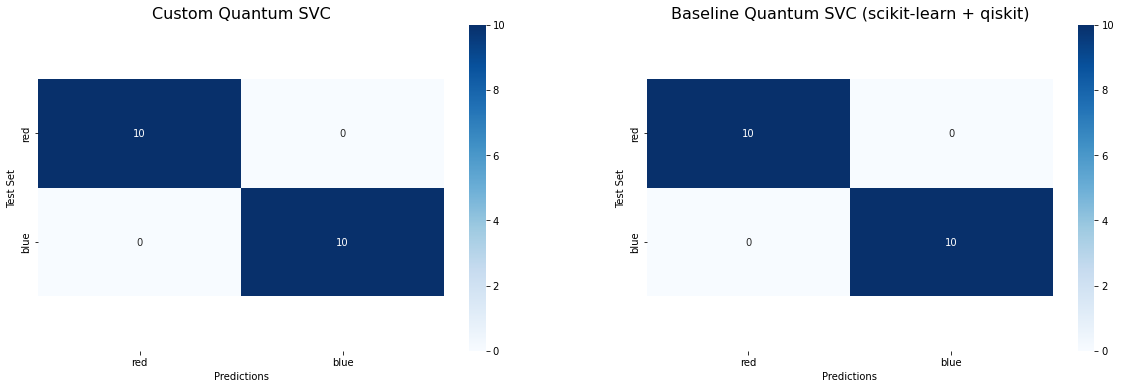

In [84]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum, True, mode='test')
print(f'Baseline Accuracy: {baseline_acc_adhoc_quantum*100} %')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum,
    y_adhoc_pred_baseline_quantum,
    colors, 
    titles=["Custom Quantum SVC", "Baseline Quantum SVC (scikit-learn + qiskit)"]
)

### Compare Quantum Kernel to rbf Kernel on adhoc data

100%|██████████████████████████████████████| 400/400 [10:07<00:00,  1.52s/batch]


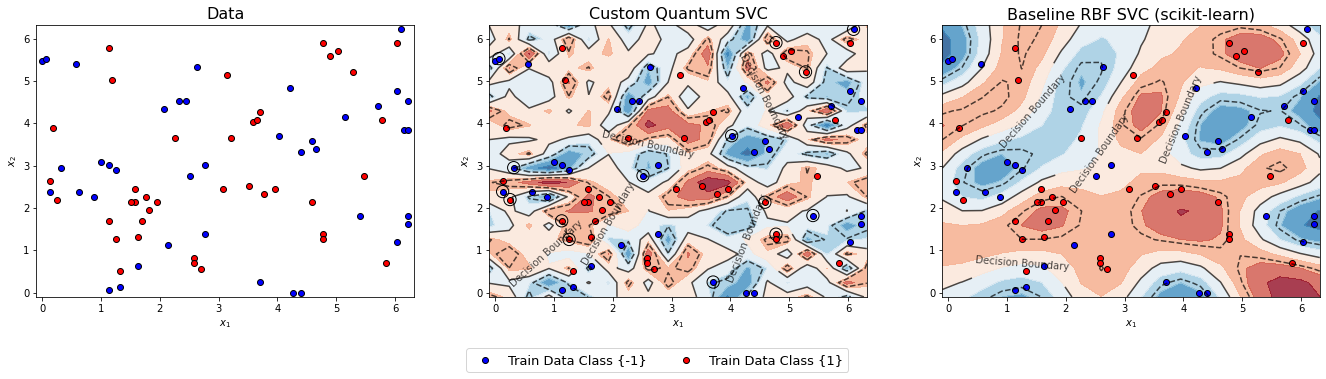

In [85]:
plot_kernel_SVC(
    X_adhoc_train, 
    y_adhoc_train, 
    [quantum_SVC, baseline_rbf_kernel_SVC_adhoc], 
    cmap, 
    titles=["Data", "Custom Quantum SVC", "Baseline RBF SVC (scikit-learn)"], 
    kernel='quantum')

Accuracy on test set: 100.0 %
Accuracy on test set: 70.0 %


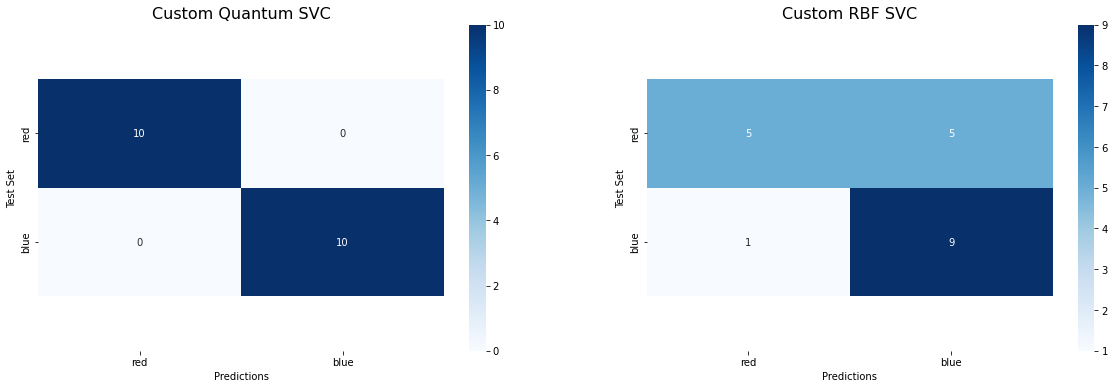

In [86]:
# accuracy
accuracy(y_adhoc_test, y_adhoc_pred_quantum, True, mode='test')
accuracy(y_adhoc_test, y_adhoc_pred_rbf, True, mode='test')

# confusion Matrix plot
plot_confusion_matrix(
    y_adhoc_test, 
    y_adhoc_pred_quantum,
    y_adhoc_pred_rbf,
    colors, 
    titles=["Custom Quantum SVC", "Custom RBF SVC"]
)

### SVC Benchmark

In [263]:
# Custom
"""classifiers_custom = [
    kernelSVC(kernel='linear', C=10, verbose=False),
    kernelSVC(kernel='polynominal', C=10, verbose=False),
    kernelSVC(kernel='sigmoid', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=1000, verbose=False),
]
"""
QK = quantum_kernel_loader(quantum_params)

classifiers_custom = [
    kernelSVC(kernel='linear', C=10, verbose=False),
    kernelSVC(kernel='polynominal', C=10, verbose=False),
    kernelSVC(kernel='sigmoid', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=1000, verbose=False),
    kernelSVC(
        kernel='quantum', 
        quantum_parans=quantum_params,
        data_map=data_map,
        qiskit=False,
        verbose=False
    ),
]

SVC(kernel='linear', C=10.0)
SVC(kernel='polynominal', C=10.0, degree=3)
SVC(kernel='sigmoid', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=1000.0, gamma=0.5)
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')


In [267]:
model_performance_custom_SVC = compare_model_performance(
                                        datasets, 
                                        classifiers_custom, 
                                        ['Linearly Separately Data', 'Linearly Separately Data', 'XOR Data', 'Circles Data', 'Moons Data', 'Adhoc Data'],
                                        ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100', 'Quantum'],
                                )

Time to compute: 249.7677250981331 min


In [265]:
df_without_quantum = pd.DataFrame.from_dict(model_performance_custom_SVC).transpose()
df_without_quantum

Linear  Polynomoinal  Sigmoid  RBF C=10  RBF C=100
Linearly Separately Data   0.975         0.975    0.975     0.975      0.975
XOR Data                   0.350         0.950    0.400     1.000      1.000
Circles Data               0.400         1.000    0.275     1.000      1.000
Moons Data                 0.750         0.750    0.750     0.750      0.850
Adhoc Data                 0.300         0.250    0.300     0.500      0.550

In [268]:
df_with_quantum = pd.DataFrame.from_dict(model_performance_custom_SVC).transpose()
df_with_quantum

Linear  Polynomoinal  Sigmoid  RBF C=10  RBF C=100  \
Linearly Separately Data   0.975         0.975    0.975     0.975      0.975   
XOR Data                   0.350         0.950    0.400     1.000      1.000   
Circles Data               0.400         1.000    0.275     1.000      1.000   
Moons Data                 0.750         0.750    0.750     0.750      0.850   
Adhoc Data                 0.300         0.250    0.300     0.500      0.550   

                          Quantum  
Linearly Separately Data    0.950  
XOR Data                    0.950  
Circles Data                0.975  
Moons Data                  0.850  
Adhoc Data                  1.000

In [272]:
# SVC 
QK = quantum_kernel_loader(quantum_params)

"""
classifiers = [
    SVC(kernel='linear', C=10),
    SVC(kernel='poly', C=10, degree=3),
    SVC(kernel='sigmoid', C=10, gamma=0.5),
    SVC(kernel='rbf', C=10, gamma=0.5),
    SVC(kernel='rbf', C=1000, gamma=0.5),
]
"""
classifiers = [
    SVC(kernel='linear', C=10),
    SVC(kernel='poly', C=10, degree=3),
    SVC(kernel='sigmoid', C=10, gamma=0.5),
    SVC(kernel='rbf', C=10, gamma=0.5),
    SVC(kernel='rbf', C=1000, gamma=0.5),
    SVC(kernel=QK),
]

In [273]:
model_performance_scikit_SVC = compare_model_performance(
                                        datasets, 
                                        classifiers, 
                                        ['Linearly Separately Data', 'Linearly Separately Data', 'XOR Data', 'Circles Data', 'Moons Data', 'Adhoc Data'],
                                        ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100', 'Quantum']
                                )

Time to compute: 31.12842531998952 min


In [271]:
df_without_quantum_scikit = pd.DataFrame.from_dict(model_performance_scikit_SVC).transpose()
df_without_quantum_scikit

Linear  Polynomoinal  Sigmoid  RBF C=10  RBF C=100
Linearly Separately Data   0.975         0.975     0.95     0.975      0.975
XOR Data                   0.500         0.950     0.35     1.000      1.000
Circles Data               0.400         0.800     0.30     1.000      1.000
Moons Data                 0.750         0.725     0.75     0.725      0.875
Adhoc Data                 0.350         0.300     0.40     0.500      0.550

In [274]:
df_with_quantum_scikit = pd.DataFrame.from_dict(model_performance_scikit_SVC).transpose()
df_with_quantum_scikit

Linear  Polynomoinal  Sigmoid  RBF C=10  RBF C=100  \
Linearly Separately Data   0.975         0.975     0.95     0.975      0.975   
XOR Data                   0.500         0.950     0.35     1.000      1.000   
Circles Data               0.400         0.800     0.30     1.000      1.000   
Moons Data                 0.750         0.725     0.75     0.725      0.875   
Adhoc Data                 0.350         0.300     0.40     0.500      0.550   

                          Quantum  
Linearly Separately Data    0.950  
XOR Data                    0.950  
Circles Data                0.975  
Moons Data                  0.800  
Adhoc Data                  1.000

[Return to Content](#Content)

## Kernel Comparisson

In [155]:
QK = quantum_kernel_loader(quantum_params)

classifiers = [
    kernelSVC(kernel='linear', C=10, verbose=False),
    kernelSVC(kernel='polynominal', C=10, verbose=False),
    kernelSVC(kernel='sigmoid', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=1000, verbose=False),
    kernelSVC(
        kernel='quantum', 
        quantum_parans=quantum_params,
        data_map=data_map,
        qiskit=False,
        verbose=False
    ),
]

SVC(kernel='linear', C=10.0)
SVC(kernel='polynominal', C=10.0, degree=3)
SVC(kernel='sigmoid', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=1000.0, gamma=0.5)
SVC(kernel='quantum, feature_map='ZZFeatureMap', data_map='phi_S : x --> {x if S={i}, (pi - x[0])(pi - x[0] if S={i,j})'')


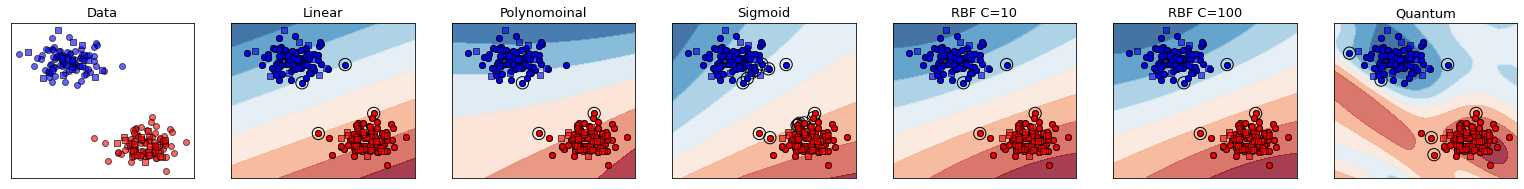

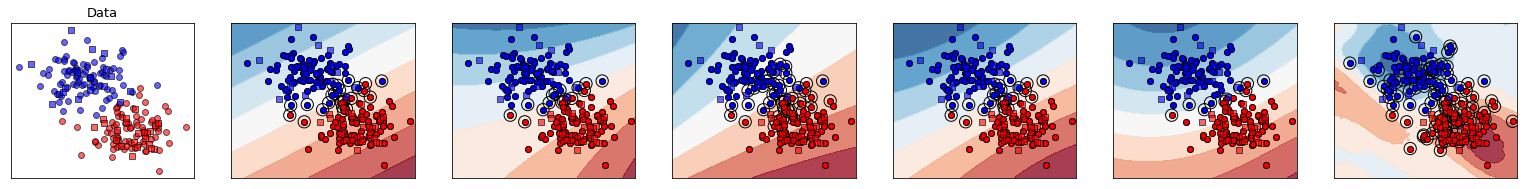

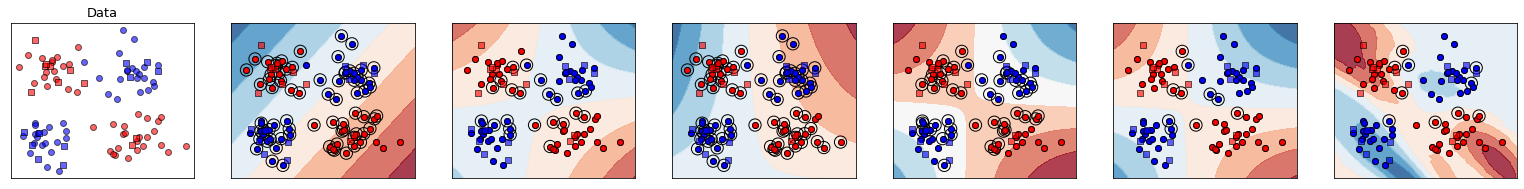

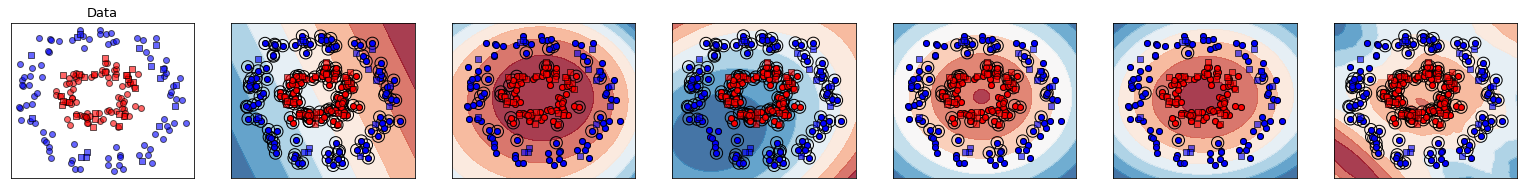

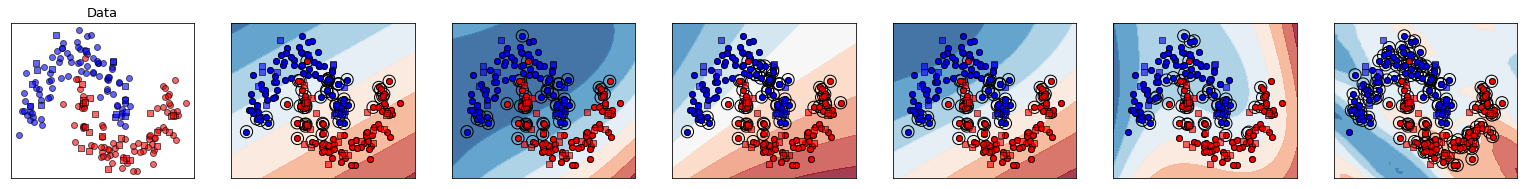

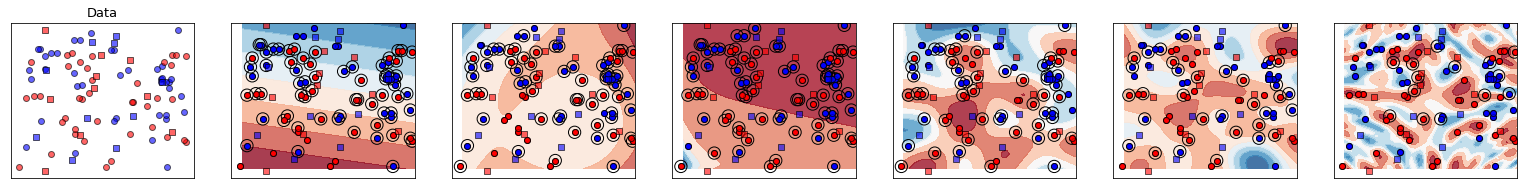

Time to compute: 1943.6678391973178 min


In [157]:
compare_models(
    datasets, 
    classifiers, 
    ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100', 'Quantum'], 
    scikit=False
)

In [228]:
#use scikit model for comparison - due to time consumption other
#QK = quantum_kernel_loader(quantum_params)

classifiers = [
    SVC(kernel='linear', C=10),
    SVC(kernel='poly', C=10, degree=3),
    SVC(kernel='sigmoid', C=10, gamma=0.5),
    SVC(kernel='rbf', C=10, gamma=0.5),
    SVC(kernel='rbf', C=1000, gamma=0.5),
    #SVC(kernel=QK),
]

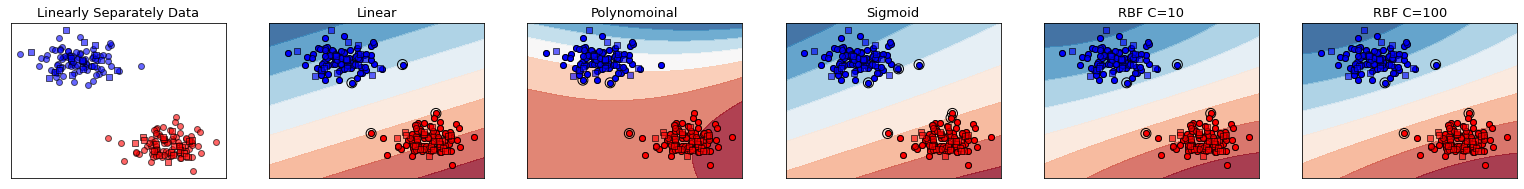

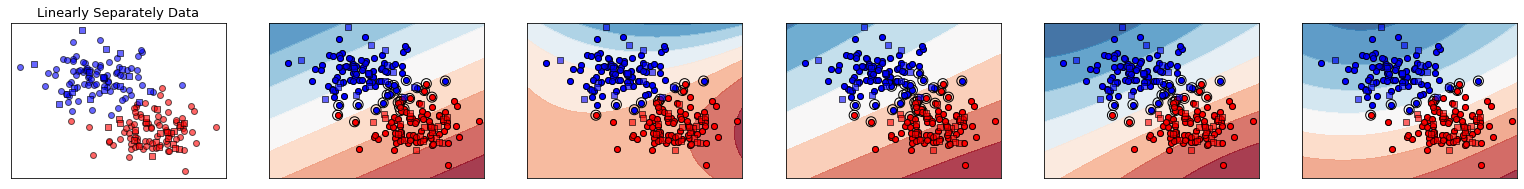

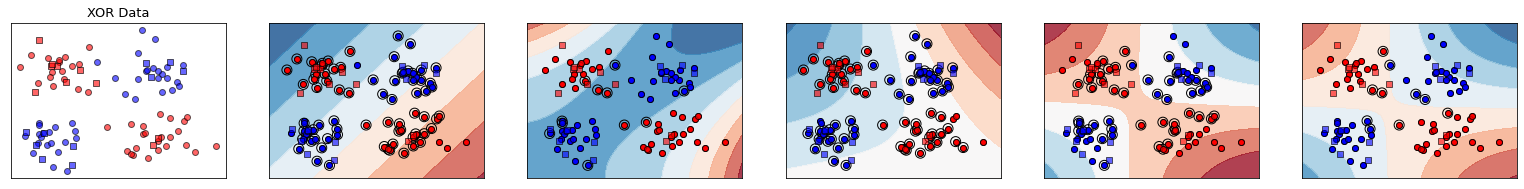

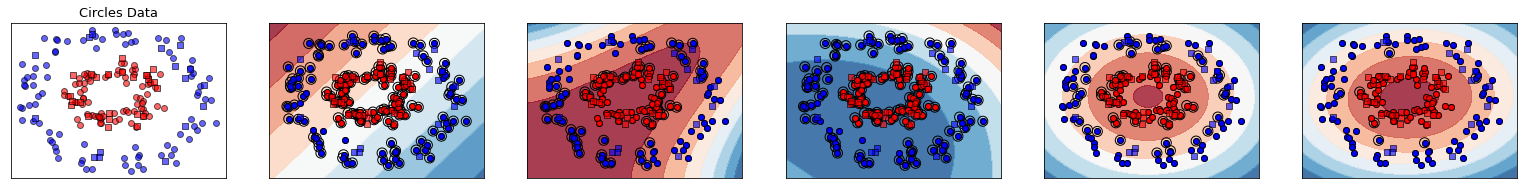

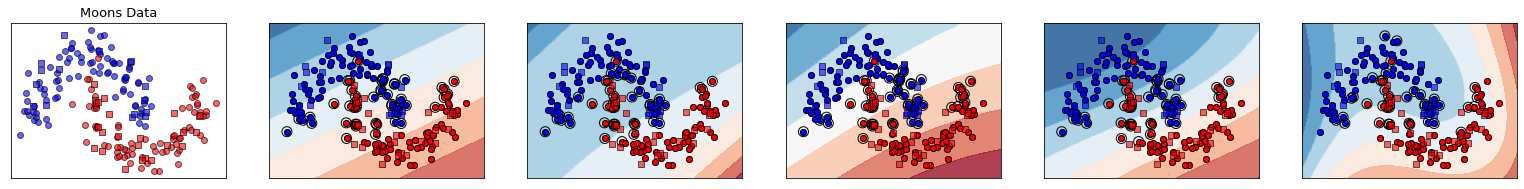

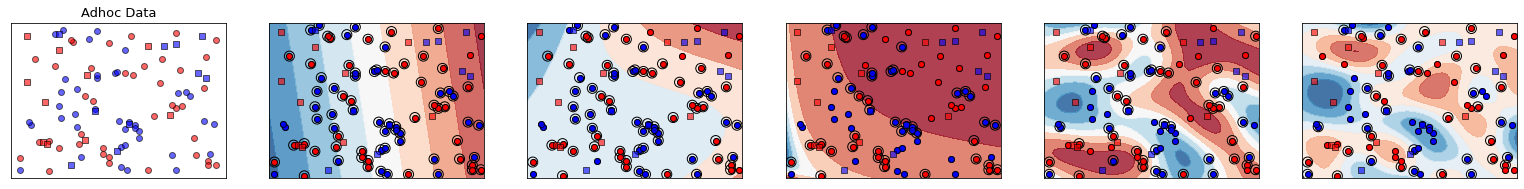

Time to compute: 0.0660082976023356 min


In [230]:
compare_models(
    datasets, 
    classifiers,
    ['Linearly Separately Data', 'Linearly Separately Data', 'XOR Data', 'Circles Data', 'Moons Data', 'Adhoc Data'],
    ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100'],# 'Quantum'], 
    scikit=True
)

In [239]:
# custom implementation
classifiers_custom = [
    kernelSVC(kernel='linear', C=10, verbose=False),
    kernelSVC(kernel='polynominal', C=10, verbose=False),
    kernelSVC(kernel='sigmoid', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=10, verbose=False),
    kernelSVC(kernel='rbf', C=1000, verbose=False),
]

SVC(kernel='linear', C=10.0)
SVC(kernel='polynominal', C=10.0, degree=3)
SVC(kernel='sigmoid', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=10.0, gamma=0.5)
SVC(kernel='rbf', C=1000.0, gamma=0.5)


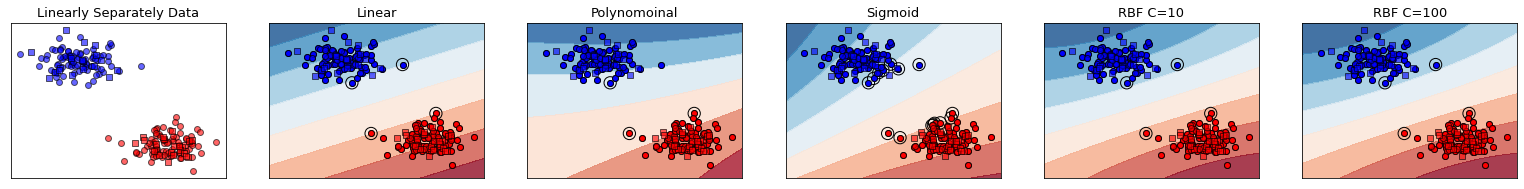

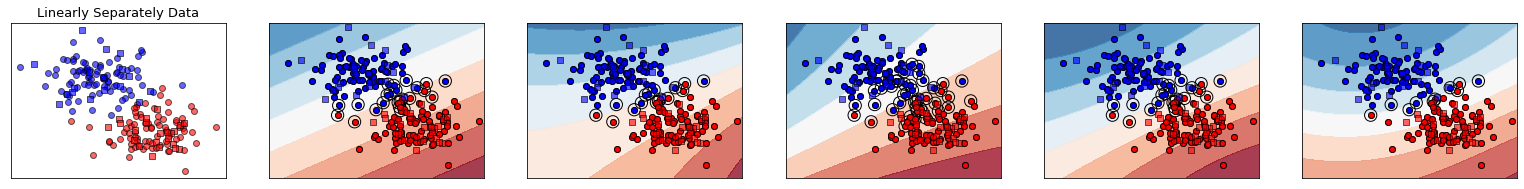

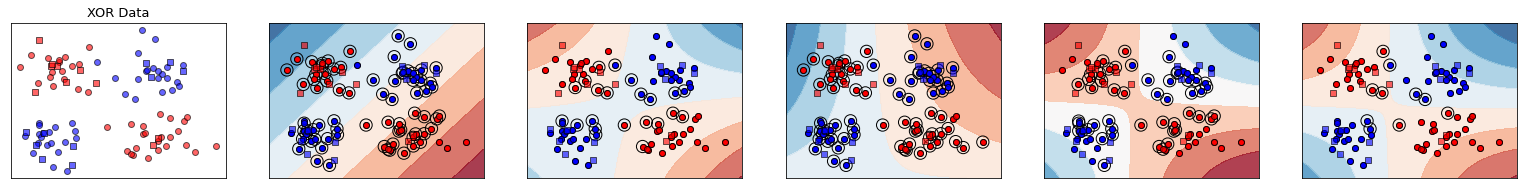

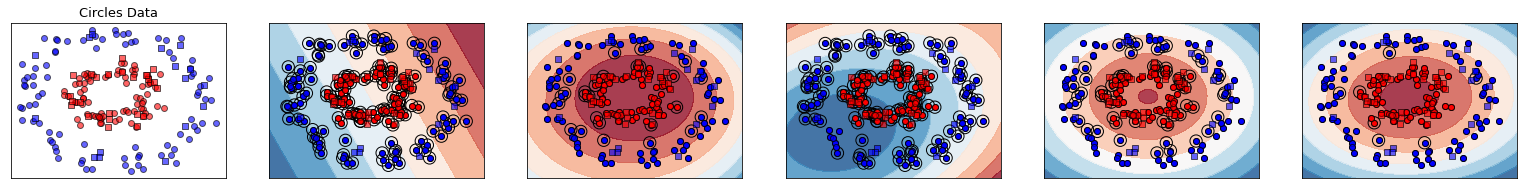

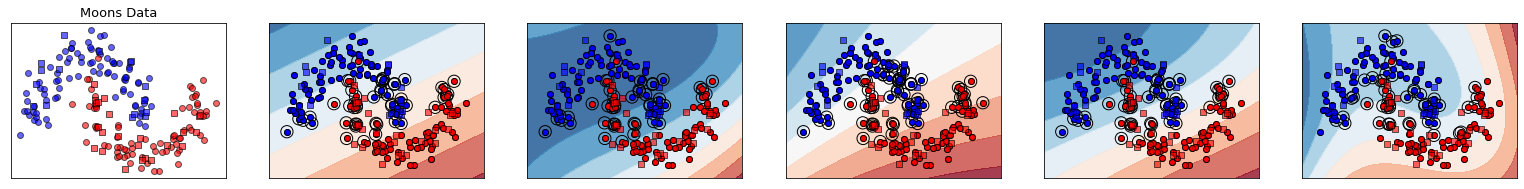

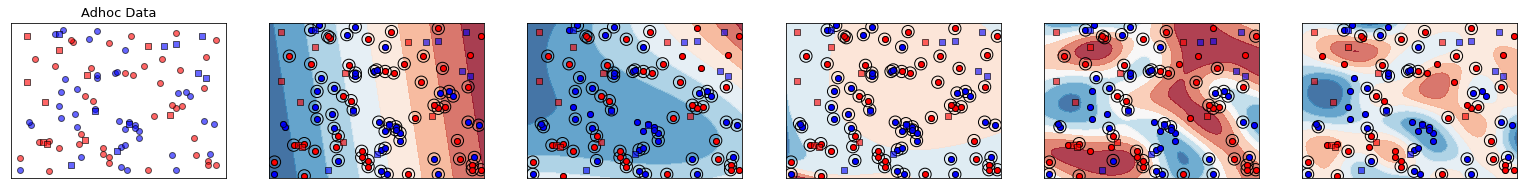

Time to compute: 0.4431579192479452 min


In [240]:
compare_models(
    datasets, 
    classifiers_custom,
    ['Linearly Separately Data', 'Linearly Separately Data', 'XOR Data', 'Circles Data', 'Moons Data', 'Adhoc Data'],
    ['Linear', 'Polynomoinal', 'Sigmoid', 'RBF C=10', 'RBF C=100'],# 'Quantum'],
    
)

[Return to Content](#Content)

### References

N. Mishra, M. Kapil, H. Rakesh, A. Anand, N. Mishra, A. Warke, S. Sarkar, S. Dutta,S. Gupta, A. P. Dash,et al., “Quantum machine learning: A review and current status”,Data Management, Analytics and Innovation, pp. 101–145, 2021.

Y. Liu, S. Arunachalam, and K. Temme, “A rigorous and robust quantum speed-up insupervised machine learning”,Nature Physics, vol. 17, no. 9, pp. 1013–1017, 2021.J. 

Biamonte, P. Wittek, N. Pancotti, P. Rebentrost, N. Wiebe, and S. Lloyd, “Quantummachine learning”,Nature, vol. 549, no. 7671, pp. 195–202, 2017.

C. M. Bishop,Pattern Recognition and Machine Learning. Springer, 2006.

S. Boyd, S. P. Boyd, and L. Vandenberghe,Convex optimization. Cambridge universitypress, 2004.

Y. Suzuki, H. Yano, Q. Gao, S. Uno, T. Tanaka, M. Akiyama, and N. Yamamoto,“Analysis and synthesis of feature map for kernel-based quantum classifier”,QuantumMachine Intelligence, vol. 2, no. 1, pp. 1–9, 2020.V. 

Havlıˇcek, A. D. Córcoles, K. Temme, A. W. Harrow, A. Kandala, J. M. Chow, andJ. M. Gambetta, “Supervised learning with quantum-enhanced feature spaces”,Nature, vol. 567, no. 7747, pp. 209–212, 2019.

A. Phan. (2021), 2021 qiskit global summer school on quantum machine learning - lab3: Introduction to quantum kernels and svms,  [Online]. Available:https://learn.qiskit.org/summer-school/2021/lab3-introduction-quantum-kernels-support-vector-machines(visited on 11/29/2021).